In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
%matplotlib inline

import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Dropout, BatchNormalization, UpSampling2D, Concatenate
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, Callback
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
K.get_session().list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 2887118617552),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 2887118617104)]

In [3]:
# Set some parameters

img_size_ori = 101
img_size_target = 128
img_chan = 1
path_train = '../data/train/'
path_test = '../data/test/'

remove_suspicious_masks = True

In [57]:
# Helper functions

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)


# Define IoU metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)


def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


def show_images(image_ids, images_folder, masks_folder=None, predictions=None, prediction_threshold=.5,
                max_images=40, grid_width=8, figsize=(20, 15),                 
                random_sample=False):
    
    grid_height = int(max_images / grid_width)
    selected_indexes = np.random.randint(image_ids.shape[0], size=max_images) if random else np.arange(max_images)
    ids = np.take(image_ids, selected_indexes, axis=0)
    images = [np.array(load_img(images_folder + "/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(ids)]    
    masks = None
    if masks_folder is not None:
        masks = [np.array(load_img(masks_folder + "/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(ids)]    
    depths_df = pd.read_csv("../data/depths.csv", index_col="id")
    preds = None if predictions is None else np.take(predictions, selected_indexes, axis=0)
    
    fig, axs = plt.subplots(grid_height, grid_width, figsize=figsize)
    
    for i, idx in enumerate(ids):
        ax = axs[int(i / grid_width), i % grid_width]
        ax.imshow(images[i], cmap="Greys")
        ax.text(1, img_size_ori-1, depths_df.loc[idx].z, color="black")
        
        if masks is not None:
            coverage = np.sum(masks[i]) / (img_size_ori * img_size_ori)
            coverage_class = np.trunc(coverage * 10)           
            ax.imshow(masks[i], alpha=0.3, cmap="Greens")
            ax.text(img_size_ori - 1, 1, round(coverage, 2), color="black", ha="right", va="top")
            ax.text(1, 1, coverage_class, color="black", ha="left", va="top") 
        
        if preds is not None:
            ax.imshow(np.array(np.round(preds[i] > prediction_threshold), dtype=np.float32), alpha=0.3, cmap="OrRd")       

        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")



# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

# Data Exploration
Let's look at some data. We can see that TGS chose to use very varied data by inspecting. That is great and adresses a problem in deep learning geoscience at the moment. We build models on one type of seismic and have no idea whether it generalizes.

In [5]:
train_df = pd.read_csv("../data/train.csv", index_col="id")
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

train_df["images"] = [np.array(load_img(path_train + "images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]
test_df["images"] = [np.array(load_img(path_test + "images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(test_df.index)]

train_df["masks"] = [np.array(load_img(path_train + "masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]


train_df["coverage"] = train_df.masks.map(np.sum) / (101*101)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
train_df.fillna('', inplace=True)
train_df['suspicious'] = False

for index, row in train_df.iterrows():
    encoded_mask = row['rle_mask'].split(' ')
    if len(encoded_mask) > 1 and len(encoded_mask) < 5 and int(encoded_mask[1]) % 101 == 0:
        train_df.loc[index,'suspicious'] = True

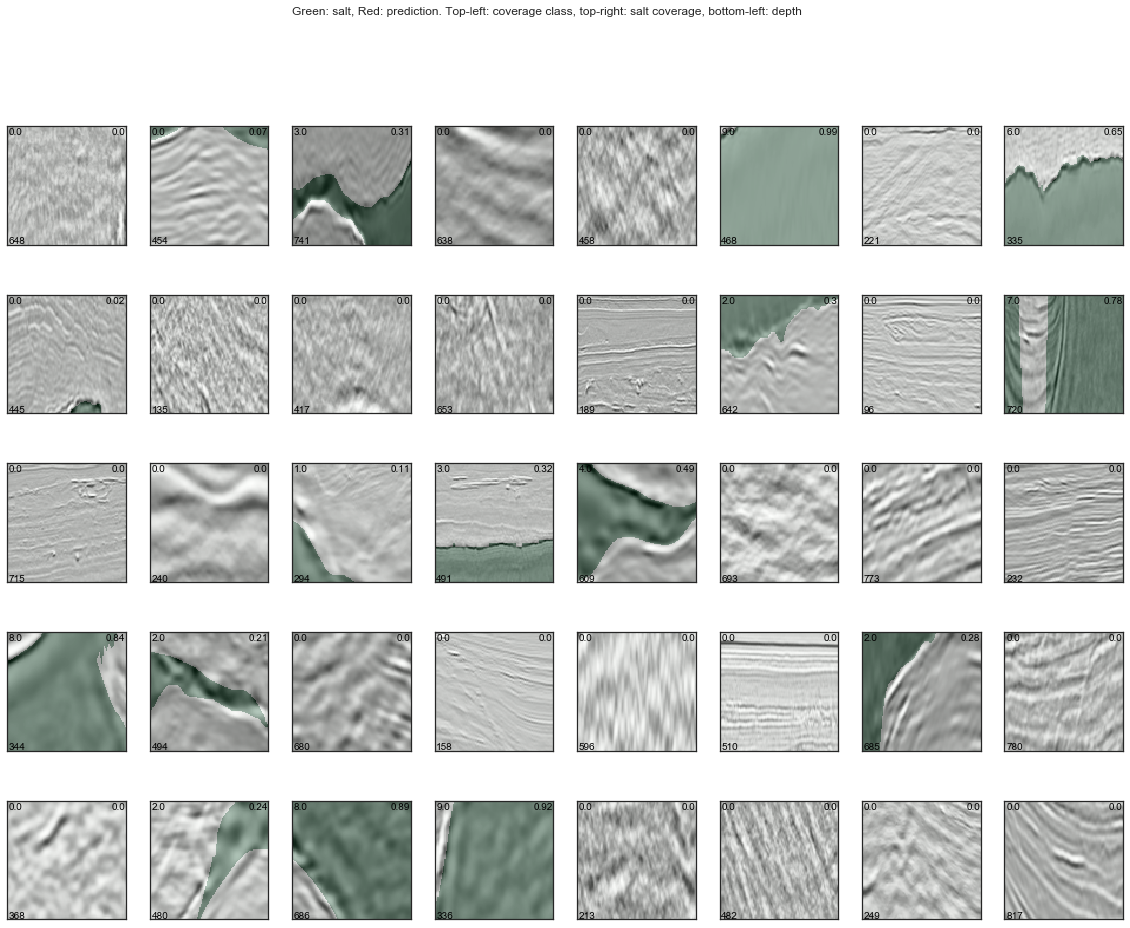

## Suspicious masks

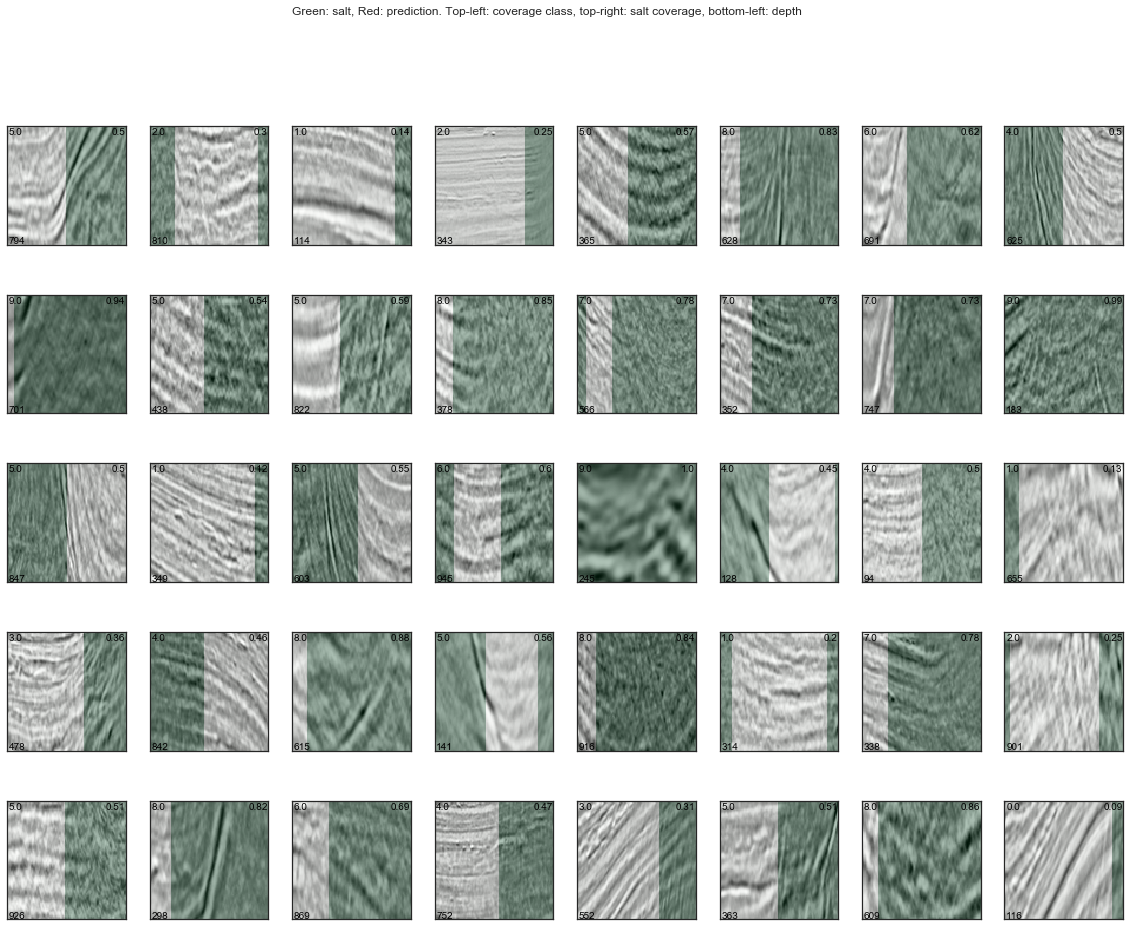

In [8]:
show_images(train_df.loc[train_df.suspicious == True].index, images_folder= path_train + 'images', masks_folder= path_train + 'masks')

In [9]:
if remove_suspicious_masks:
    train_df = train_df.loc[train_df.suspicious == False]

Text(0.5,0,'Coverage class')

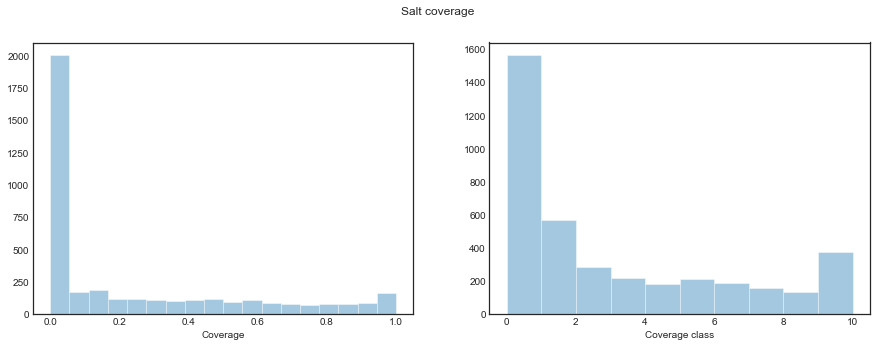

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

,coverage,z
coverage,1.00000,0.10236
z,0.10236,1.00000


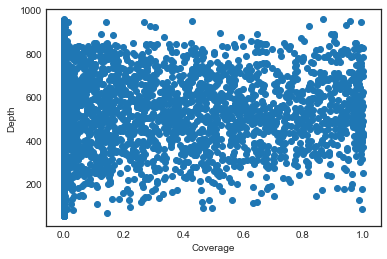

In [11]:
plt.scatter(train_df.coverage, train_df.z)
plt.xlabel("Coverage")
plt.ylabel("Depth")


train_df[['coverage','z']].corr()

Text(0.5,1,'Depth distribution')

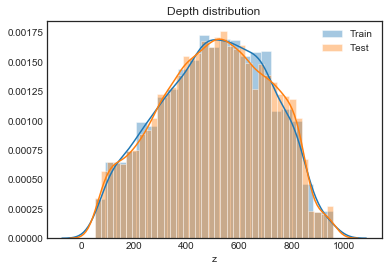

In [12]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

We have many examples without salt, as you can see by the masks that are entirely dark. That's great, an algorithm we build will then know that patches exist entirely without salt. Talk about biasing your data.

We can draw heavily on other work, instead of regurgitating the geophysics work that has been done before. I mentioned that seismic is kind of like ultrasound. So I had a look at https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

Let's throw a Unet at our data. I am blatanly stealing from Ketil at this point. All credit goes to him and his nice code.
First we'll need to get our data into a shape that works for U-Nets. That means, it should be a power of 2. Let's do it quick and dirty for now, but eventually, consider aliasing and all that fun.

In [13]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=3456)

In [14]:
np.savetxt("validation_ids.csv", ids_valid, fmt='%s')

In [15]:
# data augmentation 
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

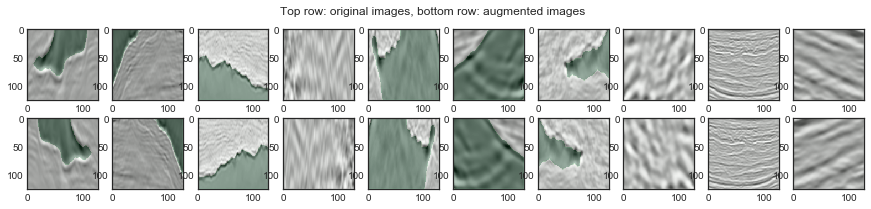

In [16]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

# Train Model
Our task, just like the segmentation task for nuclei, is evaluated on the mean IoU metric. This one isn't in keras, but obviously, we're stealing this one too from Ketil.

This is the fun part. Building the sequential Model. The U-Net is basically looking like an Auto-Encoder with shortcuts. 

We're also sprinkling in some earlystopping to prevent overfitting. If you're running this on kaggle, this is the point, you want to have GPU support.

In [80]:
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)


model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True,upconv=False)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[mean_iou])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_187 (Conv2D)              (None, 128, 128, 16)  160         input_11[0][0]                   
____________________________________________________________________________________________________
batch_normalization_179 (BatchNo (None, 128, 128, 16)  64          conv2d_187[0][0]                 
____________________________________________________________________________________________________
conv2d_188 (Conv2D)              (None, 128, 128, 16)  2320        batch_normalization_179[0][0]    
___________________________________________________________________________________________

In [ ]:
# train the model
batch_size = 16
epochs = 80

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('../models/model-tgs-salt-validation-dropout-batchnorm-{epoch:02d}-{val_loss:.2f}.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00001, verbose=1)
tb = TensorBoard(log_dir="../tb_logs", batch_size=batch_size)

history = model.fit(x_train, y_train, validation_data=[x_valid, y_valid], batch_size=batch_size, epochs=epochs, 
                    callbacks=[earlystopper, checkpointer, reduce_lr, tb])

Train on 6214 samples, validate on 777 samples
Epoch 1/80


2944/6214 [=============>................] - ETA: 1827s - loss: 0.9052 - mean_iou: 0.0000e+0 - ETA: 1366s - loss: 0.8395 - mean_iou: 0.1705    - ETA: 1208s - loss: 0.8287 - mean_iou: 0.227 - ETA: 1129s - loss: 0.8073 - mean_iou: 0.258 - ETA: 1081s - loss: 0.7758 - mean_iou: 0.279 - ETA: 1047s - loss: 0.7665 - mean_iou: 0.295 - ETA: 1023s - loss: 0.7534 - mean_iou: 0.307 - ETA: 1005s - loss: 0.7396 - mean_iou: 0.317 - ETA: 990s - loss: 0.7266 - mean_iou: 0.327 - ETA: 977s - loss: 0.7182 - mean_iou: 0.33 - ETA: 966s - loss: 0.7150 - mean_iou: 0.34 - ETA: 956s - loss: 0.7052 - mean_iou: 0.34 - ETA: 948s - loss: 0.7032 - mean_iou: 0.35 - ETA: 941s - loss: 0.6974 - mean_iou: 0.36 - ETA: 934s - loss: 0.6872 - mean_iou: 0.36 - ETA: 928s - loss: 0.6835 - mean_iou: 0.37 - ETA: 922s - loss: 0.6754 - mean_iou: 0.37 - ETA: 917s - loss: 0.6642 - mean_iou: 0.38 - ETA: 912s - loss: 0.6550 - mean_iou: 0.38 - ETA: 907s - loss: 0.6458 - mean_iou: 0.39 - ETA: 903s - loss: 0.6387 - mean_iou: 0.39 - ETA: 8

6214/6214 [==============================] - 1023s - loss: 0.3725 - mean_iou: 0.6215 - val_loss: 1.0868 - val_mean_iou: 0.6572
Epoch 2/80


2976/6214 [=============>................] - ETA: 976s - loss: 0.4259 - mean_iou: 0.65 - ETA: 939s - loss: 0.3883 - mean_iou: 0.65 - ETA: 924s - loss: 0.3425 - mean_iou: 0.65 - ETA: 916s - loss: 0.3248 - mean_iou: 0.65 - ETA: 911s - loss: 0.2943 - mean_iou: 0.65 - ETA: 907s - loss: 0.2917 - mean_iou: 0.65 - ETA: 902s - loss: 0.3256 - mean_iou: 0.65 - ETA: 899s - loss: 0.3401 - mean_iou: 0.65 - ETA: 896s - loss: 0.3299 - mean_iou: 0.65 - ETA: 893s - loss: 0.3181 - mean_iou: 0.65 - ETA: 890s - loss: 0.3162 - mean_iou: 0.65 - ETA: 887s - loss: 0.3261 - mean_iou: 0.65 - ETA: 885s - loss: 0.3168 - mean_iou: 0.65 - ETA: 882s - loss: 0.3147 - mean_iou: 0.65 - ETA: 879s - loss: 0.3066 - mean_iou: 0.65 - ETA: 876s - loss: 0.3052 - mean_iou: 0.65 - ETA: 874s - loss: 0.3114 - mean_iou: 0.65 - ETA: 871s - loss: 0.3097 - mean_iou: 0.65 - ETA: 869s - loss: 0.3094 - mean_iou: 0.65 - ETA: 866s - loss: 0.3058 - mean_iou: 0.65 - ETA: 864s - loss: 0.3059 - mean_iou: 0.65 - ETA: 861s - loss: 0.3035 - mean

6214/6214 [==============================] - 1016s - loss: 0.2450 - mean_iou: 0.6694 - val_loss: 0.1953 - val_mean_iou: 0.6883
Epoch 3/80


2976/6214 [=============>................] - ETA: 906s - loss: 0.1895 - mean_iou: 0.69 - ETA: 903s - loss: 0.2172 - mean_iou: 0.69 - ETA: 901s - loss: 0.2131 - mean_iou: 0.69 - ETA: 900s - loss: 0.1944 - mean_iou: 0.69 - ETA: 897s - loss: 0.1975 - mean_iou: 0.69 - ETA: 895s - loss: 0.1856 - mean_iou: 0.69 - ETA: 892s - loss: 0.1943 - mean_iou: 0.69 - ETA: 890s - loss: 0.1916 - mean_iou: 0.69 - ETA: 888s - loss: 0.1968 - mean_iou: 0.69 - ETA: 886s - loss: 0.1980 - mean_iou: 0.69 - ETA: 883s - loss: 0.1956 - mean_iou: 0.69 - ETA: 881s - loss: 0.2102 - mean_iou: 0.69 - ETA: 878s - loss: 0.2070 - mean_iou: 0.69 - ETA: 876s - loss: 0.2064 - mean_iou: 0.69 - ETA: 874s - loss: 0.2083 - mean_iou: 0.69 - ETA: 872s - loss: 0.2051 - mean_iou: 0.69 - ETA: 869s - loss: 0.2011 - mean_iou: 0.69 - ETA: 867s - loss: 0.2015 - mean_iou: 0.69 - ETA: 865s - loss: 0.2013 - mean_iou: 0.69 - ETA: 862s - loss: 0.1995 - mean_iou: 0.69 - ETA: 860s - loss: 0.2152 - mean_iou: 0.69 - ETA: 858s - loss: 0.2209 - mean

6214/6214 [==============================] - 1015s - loss: 0.2202 - mean_iou: 0.6988 - val_loss: 0.3546 - val_mean_iou: 0.7066
Epoch 4/80


2976/6214 [=============>................] - ETA: 905s - loss: 0.2790 - mean_iou: 0.70 - ETA: 906s - loss: 0.2536 - mean_iou: 0.70 - ETA: 904s - loss: 0.2666 - mean_iou: 0.70 - ETA: 901s - loss: 0.2468 - mean_iou: 0.70 - ETA: 898s - loss: 0.2338 - mean_iou: 0.70 - ETA: 895s - loss: 0.2249 - mean_iou: 0.70 - ETA: 893s - loss: 0.2473 - mean_iou: 0.70 - ETA: 890s - loss: 0.2527 - mean_iou: 0.70 - ETA: 888s - loss: 0.2454 - mean_iou: 0.70 - ETA: 885s - loss: 0.2437 - mean_iou: 0.70 - ETA: 883s - loss: 0.2333 - mean_iou: 0.70 - ETA: 881s - loss: 0.2254 - mean_iou: 0.70 - ETA: 879s - loss: 0.2178 - mean_iou: 0.70 - ETA: 876s - loss: 0.2141 - mean_iou: 0.70 - ETA: 874s - loss: 0.2097 - mean_iou: 0.70 - ETA: 872s - loss: 0.2115 - mean_iou: 0.70 - ETA: 869s - loss: 0.2038 - mean_iou: 0.70 - ETA: 867s - loss: 0.2003 - mean_iou: 0.70 - ETA: 865s - loss: 0.2067 - mean_iou: 0.70 - ETA: 862s - loss: 0.2009 - mean_iou: 0.70 - ETA: 860s - loss: 0.2083 - mean_iou: 0.70 - ETA: 857s - loss: 0.2030 - mean

6214/6214 [==============================] - 1015s - loss: 0.2035 - mean_iou: 0.7127 - val_loss: 0.2766 - val_mean_iou: 0.7192
Epoch 5/80


2976/6214 [=============>................] - ETA: 910s - loss: 0.4814 - mean_iou: 0.72 - ETA: 906s - loss: 0.3133 - mean_iou: 0.72 - ETA: 903s - loss: 0.2783 - mean_iou: 0.72 - ETA: 900s - loss: 0.2639 - mean_iou: 0.72 - ETA: 897s - loss: 0.2435 - mean_iou: 0.72 - ETA: 895s - loss: 0.2274 - mean_iou: 0.72 - ETA: 892s - loss: 0.2311 - mean_iou: 0.72 - ETA: 890s - loss: 0.2304 - mean_iou: 0.72 - ETA: 888s - loss: 0.2224 - mean_iou: 0.72 - ETA: 886s - loss: 0.2361 - mean_iou: 0.72 - ETA: 884s - loss: 0.2691 - mean_iou: 0.72 - ETA: 881s - loss: 0.2688 - mean_iou: 0.72 - ETA: 879s - loss: 0.2612 - mean_iou: 0.72 - ETA: 876s - loss: 0.2539 - mean_iou: 0.72 - ETA: 874s - loss: 0.2480 - mean_iou: 0.72 - ETA: 872s - loss: 0.2445 - mean_iou: 0.72 - ETA: 870s - loss: 0.2360 - mean_iou: 0.72 - ETA: 867s - loss: 0.2395 - mean_iou: 0.72 - ETA: 865s - loss: 0.2349 - mean_iou: 0.72 - ETA: 863s - loss: 0.2321 - mean_iou: 0.72 - ETA: 860s - loss: 0.2296 - mean_iou: 0.72 - ETA: 858s - loss: 0.2324 - mean

6214/6214 [==============================] - 1016s - loss: 0.1916 - mean_iou: 0.7241 - val_loss: 0.1510 - val_mean_iou: 0.7298
Epoch 6/80


2976/6214 [=============>................] - ETA: 908s - loss: 0.0959 - mean_iou: 0.73 - ETA: 906s - loss: 0.1122 - mean_iou: 0.73 - ETA: 902s - loss: 0.1053 - mean_iou: 0.73 - ETA: 900s - loss: 0.0979 - mean_iou: 0.73 - ETA: 898s - loss: 0.1004 - mean_iou: 0.73 - ETA: 896s - loss: 0.1206 - mean_iou: 0.73 - ETA: 894s - loss: 0.1311 - mean_iou: 0.73 - ETA: 891s - loss: 0.1312 - mean_iou: 0.73 - ETA: 889s - loss: 0.1278 - mean_iou: 0.73 - ETA: 887s - loss: 0.1326 - mean_iou: 0.73 - ETA: 884s - loss: 0.1298 - mean_iou: 0.73 - ETA: 882s - loss: 0.1245 - mean_iou: 0.73 - ETA: 879s - loss: 0.1405 - mean_iou: 0.73 - ETA: 877s - loss: 0.1357 - mean_iou: 0.73 - ETA: 875s - loss: 0.1617 - mean_iou: 0.73 - ETA: 873s - loss: 0.1574 - mean_iou: 0.73 - ETA: 870s - loss: 0.1597 - mean_iou: 0.73 - ETA: 868s - loss: 0.1590 - mean_iou: 0.73 - ETA: 866s - loss: 0.1566 - mean_iou: 0.73 - ETA: 863s - loss: 0.1526 - mean_iou: 0.73 - ETA: 861s - loss: 0.1507 - mean_iou: 0.73 - ETA: 858s - loss: 0.1490 - mean

6214/6214 [==============================] - 1015s - loss: 0.1674 - mean_iou: 0.7362 - val_loss: 0.1715 - val_mean_iou: 0.7419
Epoch 7/80


2976/6214 [=============>................] - ETA: 907s - loss: 0.1091 - mean_iou: 0.74 - ETA: 906s - loss: 0.0965 - mean_iou: 0.74 - ETA: 903s - loss: 0.1138 - mean_iou: 0.74 - ETA: 900s - loss: 0.1768 - mean_iou: 0.74 - ETA: 898s - loss: 0.1787 - mean_iou: 0.74 - ETA: 895s - loss: 0.1774 - mean_iou: 0.74 - ETA: 893s - loss: 0.1726 - mean_iou: 0.74 - ETA: 891s - loss: 0.1605 - mean_iou: 0.74 - ETA: 889s - loss: 0.1531 - mean_iou: 0.74 - ETA: 887s - loss: 0.1726 - mean_iou: 0.74 - ETA: 884s - loss: 0.1790 - mean_iou: 0.74 - ETA: 882s - loss: 0.1737 - mean_iou: 0.74 - ETA: 879s - loss: 0.1650 - mean_iou: 0.74 - ETA: 877s - loss: 0.1612 - mean_iou: 0.74 - ETA: 875s - loss: 0.1583 - mean_iou: 0.74 - ETA: 872s - loss: 0.1581 - mean_iou: 0.74 - ETA: 870s - loss: 0.1561 - mean_iou: 0.74 - ETA: 867s - loss: 0.1684 - mean_iou: 0.74 - ETA: 865s - loss: 0.1714 - mean_iou: 0.74 - ETA: 863s - loss: 0.1706 - mean_iou: 0.74 - ETA: 861s - loss: 0.1709 - mean_iou: 0.74 - ETA: 858s - loss: 0.1813 - mean

6214/6214 [==============================] - 1015s - loss: 0.1592 - mean_iou: 0.7466 - val_loss: 0.1362 - val_mean_iou: 0.7516
Epoch 8/80


2976/6214 [=============>................] - ETA: 910s - loss: 0.2431 - mean_iou: 0.75 - ETA: 908s - loss: 0.1962 - mean_iou: 0.75 - ETA: 906s - loss: 0.1762 - mean_iou: 0.75 - ETA: 903s - loss: 0.1452 - mean_iou: 0.75 - ETA: 900s - loss: 0.1304 - mean_iou: 0.75 - ETA: 897s - loss: 0.1346 - mean_iou: 0.75 - ETA: 894s - loss: 0.1247 - mean_iou: 0.75 - ETA: 891s - loss: 0.1216 - mean_iou: 0.75 - ETA: 889s - loss: 0.1171 - mean_iou: 0.75 - ETA: 887s - loss: 0.1405 - mean_iou: 0.75 - ETA: 884s - loss: 0.1497 - mean_iou: 0.75 - ETA: 882s - loss: 0.1446 - mean_iou: 0.75 - ETA: 880s - loss: 0.1426 - mean_iou: 0.75 - ETA: 877s - loss: 0.1513 - mean_iou: 0.75 - ETA: 875s - loss: 0.1506 - mean_iou: 0.75 - ETA: 872s - loss: 0.1493 - mean_iou: 0.75 - ETA: 871s - loss: 0.1522 - mean_iou: 0.75 - ETA: 868s - loss: 0.1498 - mean_iou: 0.75 - ETA: 866s - loss: 0.1540 - mean_iou: 0.75 - ETA: 864s - loss: 0.1511 - mean_iou: 0.75 - ETA: 861s - loss: 0.1513 - mean_iou: 0.75 - ETA: 859s - loss: 0.1490 - mean

6214/6214 [==============================] - 1016s - loss: 0.1465 - mean_iou: 0.7561 - val_loss: 0.1244 - val_mean_iou: 0.7607
Epoch 9/80


2976/6214 [=============>................] - ETA: 909s - loss: 0.0953 - mean_iou: 0.76 - ETA: 906s - loss: 0.1024 - mean_iou: 0.76 - ETA: 902s - loss: 0.1110 - mean_iou: 0.76 - ETA: 900s - loss: 0.1981 - mean_iou: 0.76 - ETA: 898s - loss: 0.1734 - mean_iou: 0.76 - ETA: 895s - loss: 0.1753 - mean_iou: 0.76 - ETA: 893s - loss: 0.1573 - mean_iou: 0.76 - ETA: 891s - loss: 0.1461 - mean_iou: 0.76 - ETA: 888s - loss: 0.1522 - mean_iou: 0.76 - ETA: 886s - loss: 0.1570 - mean_iou: 0.76 - ETA: 883s - loss: 0.1666 - mean_iou: 0.76 - ETA: 881s - loss: 0.1602 - mean_iou: 0.76 - ETA: 879s - loss: 0.1531 - mean_iou: 0.76 - ETA: 877s - loss: 0.1477 - mean_iou: 0.76 - ETA: 874s - loss: 0.1528 - mean_iou: 0.76 - ETA: 872s - loss: 0.1634 - mean_iou: 0.76 - ETA: 869s - loss: 0.1598 - mean_iou: 0.76 - ETA: 867s - loss: 0.1643 - mean_iou: 0.76 - ETA: 865s - loss: 0.1601 - mean_iou: 0.76 - ETA: 863s - loss: 0.1571 - mean_iou: 0.76 - ETA: 860s - loss: 0.1536 - mean_iou: 0.76 - ETA: 858s - loss: 0.1556 - mean

6214/6214 [==============================] - 1016s - loss: 0.1445 - mean_iou: 0.7645 - val_loss: 0.1316 - val_mean_iou: 0.7683
Epoch 10/80


2976/6214 [=============>................] - ETA: 905s - loss: 0.0895 - mean_iou: 0.76 - ETA: 903s - loss: 0.0771 - mean_iou: 0.76 - ETA: 902s - loss: 0.2093 - mean_iou: 0.76 - ETA: 900s - loss: 0.2102 - mean_iou: 0.76 - ETA: 898s - loss: 0.1841 - mean_iou: 0.76 - ETA: 895s - loss: 0.1759 - mean_iou: 0.76 - ETA: 893s - loss: 0.1624 - mean_iou: 0.76 - ETA: 891s - loss: 0.1621 - mean_iou: 0.76 - ETA: 889s - loss: 0.1606 - mean_iou: 0.76 - ETA: 887s - loss: 0.1504 - mean_iou: 0.76 - ETA: 885s - loss: 0.1438 - mean_iou: 0.76 - ETA: 882s - loss: 0.1401 - mean_iou: 0.76 - ETA: 880s - loss: 0.1561 - mean_iou: 0.76 - ETA: 878s - loss: 0.1547 - mean_iou: 0.76 - ETA: 876s - loss: 0.1667 - mean_iou: 0.76 - ETA: 873s - loss: 0.1629 - mean_iou: 0.76 - ETA: 871s - loss: 0.1647 - mean_iou: 0.76 - ETA: 869s - loss: 0.1663 - mean_iou: 0.76 - ETA: 866s - loss: 0.1659 - mean_iou: 0.76 - ETA: 864s - loss: 0.1673 - mean_iou: 0.76 - ETA: 861s - loss: 0.1673 - mean_iou: 0.76 - ETA: 859s - loss: 0.1672 - mean

6214/6214 [==============================] - 1016s - loss: 0.1390 - mean_iou: 0.7715 - val_loss: 0.1268 - val_mean_iou: 0.7745
Epoch 11/80


2976/6214 [=============>................] - ETA: 909s - loss: 0.0658 - mean_iou: 0.77 - ETA: 907s - loss: 0.0993 - mean_iou: 0.77 - ETA: 903s - loss: 0.0837 - mean_iou: 0.77 - ETA: 901s - loss: 0.0851 - mean_iou: 0.77 - ETA: 898s - loss: 0.1450 - mean_iou: 0.77 - ETA: 896s - loss: 0.1344 - mean_iou: 0.77 - ETA: 893s - loss: 0.1438 - mean_iou: 0.77 - ETA: 891s - loss: 0.1361 - mean_iou: 0.77 - ETA: 888s - loss: 0.1295 - mean_iou: 0.77 - ETA: 886s - loss: 0.1219 - mean_iou: 0.77 - ETA: 883s - loss: 0.1215 - mean_iou: 0.77 - ETA: 881s - loss: 0.1400 - mean_iou: 0.77 - ETA: 879s - loss: 0.1431 - mean_iou: 0.77 - ETA: 877s - loss: 0.1380 - mean_iou: 0.77 - ETA: 874s - loss: 0.1376 - mean_iou: 0.77 - ETA: 872s - loss: 0.1354 - mean_iou: 0.77 - ETA: 870s - loss: 0.1361 - mean_iou: 0.77 - ETA: 867s - loss: 0.1361 - mean_iou: 0.77 - ETA: 865s - loss: 0.1354 - mean_iou: 0.77 - ETA: 863s - loss: 0.1371 - mean_iou: 0.77 - ETA: 860s - loss: 0.1342 - mean_iou: 0.77 - ETA: 858s - loss: 0.1318 - mean

6214/6214 [==============================] - 1017s - loss: 0.1317 - mean_iou: 0.7772 - val_loss: 0.1203 - val_mean_iou: 0.7803
Epoch 12/80


2976/6214 [=============>................] - ETA: 902s - loss: 0.0690 - mean_iou: 0.78 - ETA: 904s - loss: 0.0862 - mean_iou: 0.78 - ETA: 903s - loss: 0.1019 - mean_iou: 0.78 - ETA: 900s - loss: 0.0874 - mean_iou: 0.78 - ETA: 898s - loss: 0.0857 - mean_iou: 0.78 - ETA: 895s - loss: 0.0797 - mean_iou: 0.78 - ETA: 893s - loss: 0.0886 - mean_iou: 0.78 - ETA: 891s - loss: 0.0865 - mean_iou: 0.78 - ETA: 888s - loss: 0.0862 - mean_iou: 0.78 - ETA: 886s - loss: 0.0981 - mean_iou: 0.78 - ETA: 884s - loss: 0.0997 - mean_iou: 0.78 - ETA: 881s - loss: 0.1041 - mean_iou: 0.78 - ETA: 879s - loss: 0.1028 - mean_iou: 0.78 - ETA: 876s - loss: 0.1052 - mean_iou: 0.78 - ETA: 874s - loss: 0.1083 - mean_iou: 0.78 - ETA: 872s - loss: 0.1069 - mean_iou: 0.78 - ETA: 869s - loss: 0.1054 - mean_iou: 0.78 - ETA: 867s - loss: 0.1040 - mean_iou: 0.78 - ETA: 865s - loss: 0.1027 - mean_iou: 0.78 - ETA: 863s - loss: 0.1055 - mean_iou: 0.78 - ETA: 860s - loss: 0.1053 - mean_iou: 0.78 - ETA: 858s - loss: 0.1075 - mean

6214/6214 [==============================] - 1016s - loss: 0.1250 - mean_iou: 0.7830 - val_loss: 0.1124 - val_mean_iou: 0.7857
Epoch 13/80


2976/6214 [=============>................] - ETA: 907s - loss: 0.1025 - mean_iou: 0.78 - ETA: 906s - loss: 0.1178 - mean_iou: 0.78 - ETA: 904s - loss: 0.1312 - mean_iou: 0.78 - ETA: 901s - loss: 0.1237 - mean_iou: 0.78 - ETA: 899s - loss: 0.2025 - mean_iou: 0.78 - ETA: 896s - loss: 0.1822 - mean_iou: 0.78 - ETA: 894s - loss: 0.1691 - mean_iou: 0.78 - ETA: 891s - loss: 0.1578 - mean_iou: 0.78 - ETA: 889s - loss: 0.1479 - mean_iou: 0.78 - ETA: 887s - loss: 0.1408 - mean_iou: 0.78 - ETA: 884s - loss: 0.1363 - mean_iou: 0.78 - ETA: 882s - loss: 0.1298 - mean_iou: 0.78 - ETA: 879s - loss: 0.1231 - mean_iou: 0.78 - ETA: 877s - loss: 0.1275 - mean_iou: 0.78 - ETA: 875s - loss: 0.1241 - mean_iou: 0.78 - ETA: 872s - loss: 0.1194 - mean_iou: 0.78 - ETA: 870s - loss: 0.1171 - mean_iou: 0.78 - ETA: 868s - loss: 0.1133 - mean_iou: 0.78 - ETA: 865s - loss: 0.1115 - mean_iou: 0.78 - ETA: 863s - loss: 0.1121 - mean_iou: 0.78 - ETA: 861s - loss: 0.1102 - mean_iou: 0.78 - ETA: 858s - loss: 0.1122 - mean

6214/6214 [==============================] - 1015s - loss: 0.1205 - mean_iou: 0.7884 - val_loss: 0.1168 - val_mean_iou: 0.7907
Epoch 14/80


2976/6214 [=============>................] - ETA: 903s - loss: 0.0591 - mean_iou: 0.79 - ETA: 902s - loss: 0.0814 - mean_iou: 0.79 - ETA: 900s - loss: 0.0831 - mean_iou: 0.79 - ETA: 898s - loss: 0.0974 - mean_iou: 0.79 - ETA: 897s - loss: 0.1302 - mean_iou: 0.79 - ETA: 895s - loss: 0.1275 - mean_iou: 0.79 - ETA: 893s - loss: 0.1227 - mean_iou: 0.79 - ETA: 891s - loss: 0.1139 - mean_iou: 0.79 - ETA: 888s - loss: 0.1122 - mean_iou: 0.79 - ETA: 886s - loss: 0.1141 - mean_iou: 0.79 - ETA: 884s - loss: 0.1388 - mean_iou: 0.79 - ETA: 881s - loss: 0.1331 - mean_iou: 0.79 - ETA: 879s - loss: 0.1382 - mean_iou: 0.79 - ETA: 877s - loss: 0.1323 - mean_iou: 0.79 - ETA: 875s - loss: 0.1289 - mean_iou: 0.79 - ETA: 872s - loss: 0.1249 - mean_iou: 0.79 - ETA: 870s - loss: 0.1218 - mean_iou: 0.79 - ETA: 868s - loss: 0.1183 - mean_iou: 0.79 - ETA: 865s - loss: 0.1145 - mean_iou: 0.79 - ETA: 863s - loss: 0.1117 - mean_iou: 0.79 - ETA: 860s - loss: 0.1090 - mean_iou: 0.79 - ETA: 858s - loss: 0.1174 - mean

6214/6214 [==============================] - 1015s - loss: 0.1212 - mean_iou: 0.7931 - val_loss: 0.1169 - val_mean_iou: 0.7952
Epoch 15/80


2976/6214 [=============>................] - ETA: 910s - loss: 0.0636 - mean_iou: 0.79 - ETA: 905s - loss: 0.0797 - mean_iou: 0.79 - ETA: 903s - loss: 0.0682 - mean_iou: 0.79 - ETA: 900s - loss: 0.1108 - mean_iou: 0.79 - ETA: 898s - loss: 0.0992 - mean_iou: 0.79 - ETA: 895s - loss: 0.0964 - mean_iou: 0.79 - ETA: 893s - loss: 0.0885 - mean_iou: 0.79 - ETA: 891s - loss: 0.0888 - mean_iou: 0.79 - ETA: 889s - loss: 0.0889 - mean_iou: 0.79 - ETA: 886s - loss: 0.0863 - mean_iou: 0.79 - ETA: 884s - loss: 0.0881 - mean_iou: 0.79 - ETA: 882s - loss: 0.0895 - mean_iou: 0.79 - ETA: 879s - loss: 0.0955 - mean_iou: 0.79 - ETA: 877s - loss: 0.1017 - mean_iou: 0.79 - ETA: 874s - loss: 0.1000 - mean_iou: 0.79 - ETA: 872s - loss: 0.0994 - mean_iou: 0.79 - ETA: 870s - loss: 0.1033 - mean_iou: 0.79 - ETA: 867s - loss: 0.1039 - mean_iou: 0.79 - ETA: 865s - loss: 0.1018 - mean_iou: 0.79 - ETA: 863s - loss: 0.1007 - mean_iou: 0.79 - ETA: 860s - loss: 0.1080 - mean_iou: 0.79 - ETA: 858s - loss: 0.1063 - mean

6214/6214 [==============================] - 1015s - loss: 0.1092 - mean_iou: 0.7976 - val_loss: 0.1396 - val_mean_iou: 0.7997
Epoch 16/80


2976/6214 [=============>................] - ETA: 906s - loss: 0.0333 - mean_iou: 0.79 - ETA: 904s - loss: 0.0514 - mean_iou: 0.79 - ETA: 900s - loss: 0.0467 - mean_iou: 0.79 - ETA: 898s - loss: 0.0548 - mean_iou: 0.79 - ETA: 896s - loss: 0.1093 - mean_iou: 0.79 - ETA: 894s - loss: 0.1036 - mean_iou: 0.79 - ETA: 892s - loss: 0.1058 - mean_iou: 0.79 - ETA: 890s - loss: 0.1000 - mean_iou: 0.79 - ETA: 888s - loss: 0.0977 - mean_iou: 0.79 - ETA: 886s - loss: 0.0928 - mean_iou: 0.79 - ETA: 884s - loss: 0.0998 - mean_iou: 0.79 - ETA: 882s - loss: 0.1004 - mean_iou: 0.79 - ETA: 879s - loss: 0.0962 - mean_iou: 0.79 - ETA: 876s - loss: 0.1018 - mean_iou: 0.79 - ETA: 874s - loss: 0.1043 - mean_iou: 0.79 - ETA: 872s - loss: 0.1056 - mean_iou: 0.79 - ETA: 869s - loss: 0.1057 - mean_iou: 0.79 - ETA: 867s - loss: 0.1069 - mean_iou: 0.79 - ETA: 865s - loss: 0.1037 - mean_iou: 0.79 - ETA: 862s - loss: 0.1010 - mean_iou: 0.79 - ETA: 860s - loss: 0.1032 - mean_iou: 0.79 - ETA: 858s - loss: 0.1002 - mean

6214/6214 [==============================] - 1015s - loss: 0.1077 - mean_iou: 0.8017 - val_loss: 0.1362 - val_mean_iou: 0.8037
Epoch 17/80


2976/6214 [=============>................] - ETA: 909s - loss: 0.0379 - mean_iou: 0.80 - ETA: 907s - loss: 0.0599 - mean_iou: 0.80 - ETA: 904s - loss: 0.0628 - mean_iou: 0.80 - ETA: 902s - loss: 0.0550 - mean_iou: 0.80 - ETA: 899s - loss: 0.0516 - mean_iou: 0.80 - ETA: 896s - loss: 0.0526 - mean_iou: 0.80 - ETA: 893s - loss: 0.0513 - mean_iou: 0.80 - ETA: 891s - loss: 0.0711 - mean_iou: 0.80 - ETA: 890s - loss: 0.0739 - mean_iou: 0.80 - ETA: 887s - loss: 0.0796 - mean_iou: 0.80 - ETA: 884s - loss: 0.1153 - mean_iou: 0.80 - ETA: 882s - loss: 0.1112 - mean_iou: 0.80 - ETA: 879s - loss: 0.1081 - mean_iou: 0.80 - ETA: 877s - loss: 0.1060 - mean_iou: 0.80 - ETA: 875s - loss: 0.1057 - mean_iou: 0.80 - ETA: 872s - loss: 0.1079 - mean_iou: 0.80 - ETA: 870s - loss: 0.1048 - mean_iou: 0.80 - ETA: 868s - loss: 0.1051 - mean_iou: 0.80 - ETA: 866s - loss: 0.1027 - mean_iou: 0.80 - ETA: 863s - loss: 0.1005 - mean_iou: 0.80 - ETA: 861s - loss: 0.0980 - mean_iou: 0.80 - ETA: 858s - loss: 0.0964 - mean

6214/6214 [==============================] - 1016s - loss: 0.0976 - mean_iou: 0.8059 - val_loss: 0.1113 - val_mean_iou: 0.8079
Epoch 18/80


2976/6214 [=============>................] - ETA: 907s - loss: 0.0628 - mean_iou: 0.80 - ETA: 904s - loss: 0.0715 - mean_iou: 0.80 - ETA: 902s - loss: 0.0618 - mean_iou: 0.80 - ETA: 899s - loss: 0.0635 - mean_iou: 0.80 - ETA: 896s - loss: 0.0722 - mean_iou: 0.80 - ETA: 894s - loss: 0.0768 - mean_iou: 0.80 - ETA: 892s - loss: 0.0764 - mean_iou: 0.80 - ETA: 890s - loss: 0.0735 - mean_iou: 0.80 - ETA: 888s - loss: 0.0765 - mean_iou: 0.80 - ETA: 885s - loss: 0.0772 - mean_iou: 0.80 - ETA: 883s - loss: 0.0762 - mean_iou: 0.80 - ETA: 881s - loss: 0.0759 - mean_iou: 0.80 - ETA: 879s - loss: 0.0740 - mean_iou: 0.80 - ETA: 876s - loss: 0.0871 - mean_iou: 0.80 - ETA: 874s - loss: 0.0921 - mean_iou: 0.80 - ETA: 872s - loss: 0.0897 - mean_iou: 0.80 - ETA: 869s - loss: 0.0873 - mean_iou: 0.80 - ETA: 867s - loss: 0.0863 - mean_iou: 0.80 - ETA: 865s - loss: 0.0876 - mean_iou: 0.80 - ETA: 862s - loss: 0.0856 - mean_iou: 0.80 - ETA: 860s - loss: 0.0850 - mean_iou: 0.80 - ETA: 858s - loss: 0.0835 - mean

6214/6214 [==============================] - 1015s - loss: 0.0959 - mean_iou: 0.8097 - val_loss: 0.1189 - val_mean_iou: 0.8115
Epoch 19/80


2976/6214 [=============>................] - ETA: 902s - loss: 0.1009 - mean_iou: 0.81 - ETA: 902s - loss: 0.1099 - mean_iou: 0.81 - ETA: 901s - loss: 0.0935 - mean_iou: 0.81 - ETA: 899s - loss: 0.0796 - mean_iou: 0.81 - ETA: 897s - loss: 0.0839 - mean_iou: 0.81 - ETA: 894s - loss: 0.1069 - mean_iou: 0.81 - ETA: 892s - loss: 0.1002 - mean_iou: 0.81 - ETA: 890s - loss: 0.1114 - mean_iou: 0.81 - ETA: 888s - loss: 0.1050 - mean_iou: 0.81 - ETA: 886s - loss: 0.1060 - mean_iou: 0.81 - ETA: 883s - loss: 0.1037 - mean_iou: 0.81 - ETA: 881s - loss: 0.1092 - mean_iou: 0.81 - ETA: 879s - loss: 0.1055 - mean_iou: 0.81 - ETA: 876s - loss: 0.1014 - mean_iou: 0.81 - ETA: 874s - loss: 0.1018 - mean_iou: 0.81 - ETA: 872s - loss: 0.0977 - mean_iou: 0.81 - ETA: 869s - loss: 0.1098 - mean_iou: 0.81 - ETA: 867s - loss: 0.1067 - mean_iou: 0.81 - ETA: 865s - loss: 0.1030 - mean_iou: 0.81 - ETA: 863s - loss: 0.0996 - mean_iou: 0.81 - ETA: 860s - loss: 0.0976 - mean_iou: 0.81 - ETA: 858s - loss: 0.0957 - mean

6214/6214 [==============================] - 1015s - loss: 0.0921 - mean_iou: 0.8132 - val_loss: 0.1018 - val_mean_iou: 0.8151
Epoch 20/80


2976/6214 [=============>................] - ETA: 910s - loss: 0.0551 - mean_iou: 0.81 - ETA: 906s - loss: 0.0553 - mean_iou: 0.81 - ETA: 903s - loss: 0.0508 - mean_iou: 0.81 - ETA: 900s - loss: 0.0474 - mean_iou: 0.81 - ETA: 897s - loss: 0.0538 - mean_iou: 0.81 - ETA: 895s - loss: 0.0515 - mean_iou: 0.81 - ETA: 893s - loss: 0.0498 - mean_iou: 0.81 - ETA: 890s - loss: 0.0577 - mean_iou: 0.81 - ETA: 888s - loss: 0.0559 - mean_iou: 0.81 - ETA: 885s - loss: 0.0555 - mean_iou: 0.81 - ETA: 883s - loss: 0.0545 - mean_iou: 0.81 - ETA: 880s - loss: 0.0576 - mean_iou: 0.81 - ETA: 878s - loss: 0.0554 - mean_iou: 0.81 - ETA: 876s - loss: 0.0563 - mean_iou: 0.81 - ETA: 874s - loss: 0.0545 - mean_iou: 0.81 - ETA: 871s - loss: 0.0635 - mean_iou: 0.81 - ETA: 869s - loss: 0.0638 - mean_iou: 0.81 - ETA: 867s - loss: 0.0624 - mean_iou: 0.81 - ETA: 865s - loss: 0.0633 - mean_iou: 0.81 - ETA: 862s - loss: 0.0756 - mean_iou: 0.81 - ETA: 860s - loss: 0.0815 - mean_iou: 0.81 - ETA: 858s - loss: 0.0909 - mean

6214/6214 [==============================] - 1015s - loss: 0.0910 - mean_iou: 0.8169 - val_loss: 0.1065 - val_mean_iou: 0.8186
Epoch 21/80


2976/6214 [=============>................] - ETA: 904s - loss: 0.1096 - mean_iou: 0.81 - ETA: 903s - loss: 0.1040 - mean_iou: 0.81 - ETA: 903s - loss: 0.0883 - mean_iou: 0.81 - ETA: 900s - loss: 0.0847 - mean_iou: 0.81 - ETA: 897s - loss: 0.0794 - mean_iou: 0.81 - ETA: 895s - loss: 0.0920 - mean_iou: 0.81 - ETA: 893s - loss: 0.0973 - mean_iou: 0.81 - ETA: 890s - loss: 0.1035 - mean_iou: 0.81 - ETA: 888s - loss: 0.1029 - mean_iou: 0.81 - ETA: 886s - loss: 0.0985 - mean_iou: 0.81 - ETA: 884s - loss: 0.0973 - mean_iou: 0.81 - ETA: 882s - loss: 0.1020 - mean_iou: 0.81 - ETA: 880s - loss: 0.1001 - mean_iou: 0.81 - ETA: 877s - loss: 0.0965 - mean_iou: 0.81 - ETA: 875s - loss: 0.0934 - mean_iou: 0.81 - ETA: 873s - loss: 0.1036 - mean_iou: 0.81 - ETA: 870s - loss: 0.1012 - mean_iou: 0.81 - ETA: 868s - loss: 0.0973 - mean_iou: 0.81 - ETA: 865s - loss: 0.0962 - mean_iou: 0.81 - ETA: 863s - loss: 0.0941 - mean_iou: 0.81 - ETA: 861s - loss: 0.0919 - mean_iou: 0.81 - ETA: 858s - loss: 0.0912 - mean

6214/6214 [==============================] - 1015s - loss: 0.0789 - mean_iou: 0.8204 - val_loss: 0.2085 - val_mean_iou: 0.8218
Epoch 22/80


2976/6214 [=============>................] - ETA: 906s - loss: 0.0667 - mean_iou: 0.82 - ETA: 902s - loss: 0.0660 - mean_iou: 0.82 - ETA: 900s - loss: 0.0630 - mean_iou: 0.82 - ETA: 898s - loss: 0.0679 - mean_iou: 0.82 - ETA: 895s - loss: 0.0682 - mean_iou: 0.82 - ETA: 893s - loss: 0.0684 - mean_iou: 0.82 - ETA: 891s - loss: 0.0704 - mean_iou: 0.82 - ETA: 889s - loss: 0.0699 - mean_iou: 0.82 - ETA: 887s - loss: 0.0870 - mean_iou: 0.82 - ETA: 884s - loss: 0.0930 - mean_iou: 0.82 - ETA: 882s - loss: 0.0922 - mean_iou: 0.82 - ETA: 880s - loss: 0.1114 - mean_iou: 0.82 - ETA: 878s - loss: 0.1243 - mean_iou: 0.82 - ETA: 876s - loss: 0.1309 - mean_iou: 0.82 - ETA: 874s - loss: 0.1297 - mean_iou: 0.82 - ETA: 872s - loss: 0.1274 - mean_iou: 0.82 - ETA: 870s - loss: 0.1243 - mean_iou: 0.82 - ETA: 867s - loss: 0.1220 - mean_iou: 0.82 - ETA: 865s - loss: 0.1197 - mean_iou: 0.82 - ETA: 862s - loss: 0.1249 - mean_iou: 0.82 - ETA: 860s - loss: 0.1392 - mean_iou: 0.82 - ETA: 858s - loss: 0.1375 - mean

6214/6214 [==============================] - 1015s - loss: 0.1018 - mean_iou: 0.8224 - val_loss: 0.0997 - val_mean_iou: 0.8236
Epoch 23/80


2976/6214 [=============>................] - ETA: 904s - loss: 0.1206 - mean_iou: 0.82 - ETA: 903s - loss: 0.0875 - mean_iou: 0.82 - ETA: 901s - loss: 0.0741 - mean_iou: 0.82 - ETA: 899s - loss: 0.0698 - mean_iou: 0.82 - ETA: 897s - loss: 0.0834 - mean_iou: 0.82 - ETA: 895s - loss: 0.1040 - mean_iou: 0.82 - ETA: 893s - loss: 0.1021 - mean_iou: 0.82 - ETA: 890s - loss: 0.0978 - mean_iou: 0.82 - ETA: 888s - loss: 0.0936 - mean_iou: 0.82 - ETA: 886s - loss: 0.0940 - mean_iou: 0.82 - ETA: 883s - loss: 0.0920 - mean_iou: 0.82 - ETA: 881s - loss: 0.0869 - mean_iou: 0.82 - ETA: 879s - loss: 0.0883 - mean_iou: 0.82 - ETA: 876s - loss: 0.0858 - mean_iou: 0.82 - ETA: 874s - loss: 0.0837 - mean_iou: 0.82 - ETA: 872s - loss: 0.0830 - mean_iou: 0.82 - ETA: 869s - loss: 0.0839 - mean_iou: 0.82 - ETA: 867s - loss: 0.0883 - mean_iou: 0.82 - ETA: 864s - loss: 0.0889 - mean_iou: 0.82 - ETA: 862s - loss: 0.0874 - mean_iou: 0.82 - ETA: 860s - loss: 0.0860 - mean_iou: 0.82 - ETA: 858s - loss: 0.0847 - mean

6214/6214 [==============================] - 1016s - loss: 0.0800 - mean_iou: 0.8251 - val_loss: 0.0990 - val_mean_iou: 0.8267
Epoch 24/80


2976/6214 [=============>................] - ETA: 904s - loss: 0.0379 - mean_iou: 0.82 - ETA: 903s - loss: 0.0381 - mean_iou: 0.82 - ETA: 902s - loss: 0.0487 - mean_iou: 0.82 - ETA: 899s - loss: 0.0511 - mean_iou: 0.82 - ETA: 896s - loss: 0.0553 - mean_iou: 0.82 - ETA: 895s - loss: 0.0554 - mean_iou: 0.82 - ETA: 892s - loss: 0.0551 - mean_iou: 0.82 - ETA: 890s - loss: 0.0585 - mean_iou: 0.82 - ETA: 887s - loss: 0.0563 - mean_iou: 0.82 - ETA: 885s - loss: 0.0582 - mean_iou: 0.82 - ETA: 883s - loss: 0.0572 - mean_iou: 0.82 - ETA: 881s - loss: 0.0611 - mean_iou: 0.82 - ETA: 879s - loss: 0.0599 - mean_iou: 0.82 - ETA: 876s - loss: 0.0596 - mean_iou: 0.82 - ETA: 874s - loss: 0.0574 - mean_iou: 0.82 - ETA: 872s - loss: 0.0567 - mean_iou: 0.82 - ETA: 869s - loss: 0.0562 - mean_iou: 0.82 - ETA: 867s - loss: 0.0608 - mean_iou: 0.82 - ETA: 864s - loss: 0.0596 - mean_iou: 0.82 - ETA: 862s - loss: 0.0593 - mean_iou: 0.82 - ETA: 860s - loss: 0.0593 - mean_iou: 0.82 - ETA: 857s - loss: 0.0631 - mean

6214/6214 [==============================] - 1015s - loss: 0.0784 - mean_iou: 0.8282 - val_loss: 0.1105 - val_mean_iou: 0.8296
Epoch 25/80


2976/6214 [=============>................] - ETA: 902s - loss: 0.0285 - mean_iou: 0.82 - ETA: 903s - loss: 0.0323 - mean_iou: 0.82 - ETA: 902s - loss: 0.0297 - mean_iou: 0.82 - ETA: 900s - loss: 0.1047 - mean_iou: 0.82 - ETA: 898s - loss: 0.0907 - mean_iou: 0.82 - ETA: 896s - loss: 0.0973 - mean_iou: 0.82 - ETA: 893s - loss: 0.0910 - mean_iou: 0.82 - ETA: 891s - loss: 0.0837 - mean_iou: 0.82 - ETA: 888s - loss: 0.0975 - mean_iou: 0.82 - ETA: 886s - loss: 0.0915 - mean_iou: 0.82 - ETA: 883s - loss: 0.0884 - mean_iou: 0.82 - ETA: 881s - loss: 0.0854 - mean_iou: 0.82 - ETA: 878s - loss: 0.0836 - mean_iou: 0.82 - ETA: 876s - loss: 0.0842 - mean_iou: 0.82 - ETA: 874s - loss: 0.0846 - mean_iou: 0.82 - ETA: 872s - loss: 0.0838 - mean_iou: 0.82 - ETA: 869s - loss: 0.0819 - mean_iou: 0.82 - ETA: 867s - loss: 0.0798 - mean_iou: 0.82 - ETA: 865s - loss: 0.0786 - mean_iou: 0.82 - ETA: 862s - loss: 0.0782 - mean_iou: 0.82 - ETA: 860s - loss: 0.0783 - mean_iou: 0.82 - ETA: 858s - loss: 0.0779 - mean

6214/6214 [==============================] - 1015s - loss: 0.0734 - mean_iou: 0.8311 - val_loss: 0.1113 - val_mean_iou: 0.8325
Epoch 26/80


2976/6214 [=============>................] - ETA: 902s - loss: 0.0658 - mean_iou: 0.83 - ETA: 901s - loss: 0.0496 - mean_iou: 0.83 - ETA: 900s - loss: 0.0908 - mean_iou: 0.83 - ETA: 898s - loss: 0.0758 - mean_iou: 0.83 - ETA: 898s - loss: 0.0772 - mean_iou: 0.83 - ETA: 895s - loss: 0.0706 - mean_iou: 0.83 - ETA: 893s - loss: 0.0709 - mean_iou: 0.83 - ETA: 891s - loss: 0.0669 - mean_iou: 0.83 - ETA: 888s - loss: 0.0691 - mean_iou: 0.83 - ETA: 886s - loss: 0.0667 - mean_iou: 0.83 - ETA: 883s - loss: 0.0633 - mean_iou: 0.83 - ETA: 881s - loss: 0.0645 - mean_iou: 0.83 - ETA: 879s - loss: 0.0663 - mean_iou: 0.83 - ETA: 876s - loss: 0.0669 - mean_iou: 0.83 - ETA: 874s - loss: 0.0681 - mean_iou: 0.83 - ETA: 872s - loss: 0.0657 - mean_iou: 0.83 - ETA: 869s - loss: 0.0640 - mean_iou: 0.83 - ETA: 867s - loss: 0.0651 - mean_iou: 0.83 - ETA: 865s - loss: 0.0646 - mean_iou: 0.83 - ETA: 862s - loss: 0.0636 - mean_iou: 0.83 - ETA: 860s - loss: 0.0638 - mean_iou: 0.83 - ETA: 858s - loss: 0.0663 - mean

6214/6214 [==============================] - 1015s - loss: 0.0658 - mean_iou: 0.8340 - val_loss: 0.1049 - val_mean_iou: 0.8354
Epoch 27/80


2976/6214 [=============>................] - ETA: 909s - loss: 0.0353 - mean_iou: 0.83 - ETA: 904s - loss: 0.0287 - mean_iou: 0.83 - ETA: 901s - loss: 0.0370 - mean_iou: 0.83 - ETA: 899s - loss: 0.0422 - mean_iou: 0.83 - ETA: 897s - loss: 0.0418 - mean_iou: 0.83 - ETA: 895s - loss: 0.0421 - mean_iou: 0.83 - ETA: 893s - loss: 0.0652 - mean_iou: 0.83 - ETA: 891s - loss: 0.0618 - mean_iou: 0.83 - ETA: 889s - loss: 0.0590 - mean_iou: 0.83 - ETA: 886s - loss: 0.0601 - mean_iou: 0.83 - ETA: 884s - loss: 0.0603 - mean_iou: 0.83 - ETA: 882s - loss: 0.0595 - mean_iou: 0.83 - ETA: 880s - loss: 0.0599 - mean_iou: 0.83 - ETA: 878s - loss: 0.0578 - mean_iou: 0.83 - ETA: 875s - loss: 0.0560 - mean_iou: 0.83 - ETA: 873s - loss: 0.0551 - mean_iou: 0.83 - ETA: 871s - loss: 0.0543 - mean_iou: 0.83 - ETA: 868s - loss: 0.0546 - mean_iou: 0.83 - ETA: 866s - loss: 0.0538 - mean_iou: 0.83 - ETA: 863s - loss: 0.0532 - mean_iou: 0.83 - ETA: 861s - loss: 0.0557 - mean_iou: 0.83 - ETA: 859s - loss: 0.0585 - mean

6214/6214 [==============================] - 1015s - loss: 0.0654 - mean_iou: 0.8369 - val_loss: 0.1213 - val_mean_iou: 0.8381
Epoch 28/80


2976/6214 [=============>................] - ETA: 907s - loss: 0.0499 - mean_iou: 0.83 - ETA: 904s - loss: 0.0514 - mean_iou: 0.83 - ETA: 902s - loss: 0.0618 - mean_iou: 0.83 - ETA: 900s - loss: 0.0559 - mean_iou: 0.83 - ETA: 898s - loss: 0.0543 - mean_iou: 0.83 - ETA: 895s - loss: 0.0541 - mean_iou: 0.83 - ETA: 893s - loss: 0.0611 - mean_iou: 0.83 - ETA: 891s - loss: 0.0689 - mean_iou: 0.83 - ETA: 889s - loss: 0.0655 - mean_iou: 0.83 - ETA: 886s - loss: 0.0641 - mean_iou: 0.83 - ETA: 884s - loss: 0.0627 - mean_iou: 0.83 - ETA: 881s - loss: 0.0659 - mean_iou: 0.83 - ETA: 879s - loss: 0.0661 - mean_iou: 0.83 - ETA: 877s - loss: 0.0674 - mean_iou: 0.83 - ETA: 874s - loss: 0.0664 - mean_iou: 0.83 - ETA: 872s - loss: 0.0644 - mean_iou: 0.83 - ETA: 870s - loss: 0.1120 - mean_iou: 0.83 - ETA: 867s - loss: 0.1076 - mean_iou: 0.83 - ETA: 865s - loss: 0.1036 - mean_iou: 0.83 - ETA: 862s - loss: 0.1014 - mean_iou: 0.83 - ETA: 860s - loss: 0.1004 - mean_iou: 0.83 - ETA: 858s - loss: 0.0988 - mean

6214/6214 [==============================] - 1016s - loss: 0.0710 - mean_iou: 0.8393 - val_loss: 0.0974 - val_mean_iou: 0.8405
Epoch 29/80


2976/6214 [=============>................] - ETA: 904s - loss: 0.0496 - mean_iou: 0.84 - ETA: 903s - loss: 0.0729 - mean_iou: 0.84 - ETA: 902s - loss: 0.1057 - mean_iou: 0.84 - ETA: 900s - loss: 0.1037 - mean_iou: 0.84 - ETA: 898s - loss: 0.0950 - mean_iou: 0.84 - ETA: 896s - loss: 0.0896 - mean_iou: 0.84 - ETA: 894s - loss: 0.0903 - mean_iou: 0.84 - ETA: 891s - loss: 0.0854 - mean_iou: 0.84 - ETA: 888s - loss: 0.0836 - mean_iou: 0.84 - ETA: 886s - loss: 0.0834 - mean_iou: 0.84 - ETA: 884s - loss: 0.0793 - mean_iou: 0.84 - ETA: 881s - loss: 0.0789 - mean_iou: 0.84 - ETA: 879s - loss: 0.0762 - mean_iou: 0.84 - ETA: 877s - loss: 0.0760 - mean_iou: 0.84 - ETA: 874s - loss: 0.0741 - mean_iou: 0.84 - ETA: 872s - loss: 0.0722 - mean_iou: 0.84 - ETA: 869s - loss: 0.0718 - mean_iou: 0.84 - ETA: 867s - loss: 0.0711 - mean_iou: 0.84 - ETA: 865s - loss: 0.0704 - mean_iou: 0.84 - ETA: 862s - loss: 0.0691 - mean_iou: 0.84 - ETA: 860s - loss: 0.0686 - mean_iou: 0.84 - ETA: 858s - loss: 0.0670 - mean

6214/6214 [==============================] - 1015s - loss: 0.0747 - mean_iou: 0.8415 - val_loss: 0.1892 - val_mean_iou: 0.8424
Epoch 30/80


2976/6214 [=============>................] - ETA: 905s - loss: 0.0598 - mean_iou: 0.84 - ETA: 904s - loss: 0.1588 - mean_iou: 0.84 - ETA: 902s - loss: 0.1434 - mean_iou: 0.84 - ETA: 899s - loss: 0.1489 - mean_iou: 0.84 - ETA: 897s - loss: 0.1319 - mean_iou: 0.84 - ETA: 895s - loss: 0.1308 - mean_iou: 0.84 - ETA: 893s - loss: 0.1239 - mean_iou: 0.84 - ETA: 891s - loss: 0.1148 - mean_iou: 0.84 - ETA: 888s - loss: 0.1074 - mean_iou: 0.84 - ETA: 885s - loss: 0.1134 - mean_iou: 0.84 - ETA: 883s - loss: 0.1084 - mean_iou: 0.84 - ETA: 881s - loss: 0.1255 - mean_iou: 0.84 - ETA: 879s - loss: 0.1211 - mean_iou: 0.84 - ETA: 877s - loss: 0.1245 - mean_iou: 0.84 - ETA: 874s - loss: 0.1250 - mean_iou: 0.84 - ETA: 872s - loss: 0.1229 - mean_iou: 0.84 - ETA: 870s - loss: 0.1211 - mean_iou: 0.84 - ETA: 868s - loss: 0.1184 - mean_iou: 0.84 - ETA: 865s - loss: 0.1162 - mean_iou: 0.84 - ETA: 863s - loss: 0.1129 - mean_iou: 0.84 - ETA: 860s - loss: 0.1092 - mean_iou: 0.84 - ETA: 858s - loss: 0.1056 - mean

6214/6214 [==============================] - 1016s - loss: 0.0676 - mean_iou: 0.8435 - val_loss: 0.1248 - val_mean_iou: 0.8445
Epoch 31/80


2976/6214 [=============>................] - ETA: 904s - loss: 0.0707 - mean_iou: 0.84 - ETA: 903s - loss: 0.0721 - mean_iou: 0.84 - ETA: 901s - loss: 0.0648 - mean_iou: 0.84 - ETA: 900s - loss: 0.0616 - mean_iou: 0.84 - ETA: 897s - loss: 0.0596 - mean_iou: 0.84 - ETA: 895s - loss: 0.0642 - mean_iou: 0.84 - ETA: 892s - loss: 0.0600 - mean_iou: 0.84 - ETA: 889s - loss: 0.0628 - mean_iou: 0.84 - ETA: 887s - loss: 0.0595 - mean_iou: 0.84 - ETA: 885s - loss: 0.0572 - mean_iou: 0.84 - ETA: 882s - loss: 0.0532 - mean_iou: 0.84 - ETA: 880s - loss: 0.0528 - mean_iou: 0.84 - ETA: 878s - loss: 0.0529 - mean_iou: 0.84 - ETA: 876s - loss: 0.0528 - mean_iou: 0.84 - ETA: 873s - loss: 0.0512 - mean_iou: 0.84 - ETA: 871s - loss: 0.0499 - mean_iou: 0.84 - ETA: 868s - loss: 0.0526 - mean_iou: 0.84 - ETA: 867s - loss: 0.0538 - mean_iou: 0.84 - ETA: 864s - loss: 0.0541 - mean_iou: 0.84 - ETA: 862s - loss: 0.0531 - mean_iou: 0.84 - ETA: 859s - loss: 0.0534 - mean_iou: 0.84 - ETA: 857s - loss: 0.0529 - mean

6214/6214 [==============================] - 1015s - loss: 0.0648 - mean_iou: 0.8456 - val_loss: 0.1205 - val_mean_iou: 0.8466
Epoch 32/80


2976/6214 [=============>................] - ETA: 904s - loss: 0.0471 - mean_iou: 0.84 - ETA: 902s - loss: 0.0480 - mean_iou: 0.84 - ETA: 901s - loss: 0.0538 - mean_iou: 0.84 - ETA: 899s - loss: 0.0872 - mean_iou: 0.84 - ETA: 897s - loss: 0.0766 - mean_iou: 0.84 - ETA: 895s - loss: 0.0830 - mean_iou: 0.84 - ETA: 893s - loss: 0.0780 - mean_iou: 0.84 - ETA: 891s - loss: 0.0742 - mean_iou: 0.84 - ETA: 888s - loss: 0.0758 - mean_iou: 0.84 - ETA: 886s - loss: 0.0734 - mean_iou: 0.84 - ETA: 884s - loss: 0.0686 - mean_iou: 0.84 - ETA: 881s - loss: 0.0644 - mean_iou: 0.84 - ETA: 879s - loss: 0.0633 - mean_iou: 0.84 - ETA: 877s - loss: 0.0669 - mean_iou: 0.84 - ETA: 874s - loss: 0.0671 - mean_iou: 0.84 - ETA: 872s - loss: 0.0681 - mean_iou: 0.84 - ETA: 870s - loss: 0.0682 - mean_iou: 0.84 - ETA: 867s - loss: 0.0700 - mean_iou: 0.84 - ETA: 865s - loss: 0.0677 - mean_iou: 0.84 - ETA: 863s - loss: 0.0664 - mean_iou: 0.84 - ETA: 861s - loss: 0.0652 - mean_iou: 0.84 - ETA: 858s - loss: 0.0655 - mean

6214/6214 [==============================] - 1015s - loss: 0.0586 - mean_iou: 0.8476 - val_loss: 0.0999 - val_mean_iou: 0.8487
Epoch 33/80


2976/6214 [=============>................] - ETA: 906s - loss: 0.0284 - mean_iou: 0.84 - ETA: 904s - loss: 0.0332 - mean_iou: 0.84 - ETA: 902s - loss: 0.0444 - mean_iou: 0.84 - ETA: 900s - loss: 0.0427 - mean_iou: 0.84 - ETA: 898s - loss: 0.0454 - mean_iou: 0.84 - ETA: 896s - loss: 0.0436 - mean_iou: 0.84 - ETA: 893s - loss: 0.0405 - mean_iou: 0.84 - ETA: 891s - loss: 0.0389 - mean_iou: 0.84 - ETA: 888s - loss: 0.0378 - mean_iou: 0.84 - ETA: 886s - loss: 0.0368 - mean_iou: 0.84 - ETA: 883s - loss: 0.0365 - mean_iou: 0.84 - ETA: 881s - loss: 0.0371 - mean_iou: 0.84 - ETA: 879s - loss: 0.0379 - mean_iou: 0.84 - ETA: 876s - loss: 0.0364 - mean_iou: 0.84 - ETA: 874s - loss: 0.0366 - mean_iou: 0.84 - ETA: 872s - loss: 0.0360 - mean_iou: 0.84 - ETA: 869s - loss: 0.0359 - mean_iou: 0.84 - ETA: 867s - loss: 0.0372 - mean_iou: 0.84 - ETA: 865s - loss: 0.0379 - mean_iou: 0.84 - ETA: 862s - loss: 0.0380 - mean_iou: 0.84 - ETA: 860s - loss: 0.0385 - mean_iou: 0.84 - ETA: 857s - loss: 0.0423 - mean

6214/6214 [==============================] - 1015s - loss: 0.0537 - mean_iou: 0.8498 - val_loss: 0.1033 - val_mean_iou: 0.8510
Epoch 34/80


2976/6214 [=============>................] - ETA: 902s - loss: 0.0215 - mean_iou: 0.85 - ETA: 902s - loss: 0.0317 - mean_iou: 0.85 - ETA: 900s - loss: 0.0400 - mean_iou: 0.85 - ETA: 898s - loss: 0.0382 - mean_iou: 0.85 - ETA: 895s - loss: 0.0409 - mean_iou: 0.85 - ETA: 894s - loss: 0.0408 - mean_iou: 0.85 - ETA: 891s - loss: 0.0582 - mean_iou: 0.85 - ETA: 890s - loss: 0.0565 - mean_iou: 0.85 - ETA: 887s - loss: 0.0567 - mean_iou: 0.85 - ETA: 885s - loss: 0.0554 - mean_iou: 0.85 - ETA: 883s - loss: 0.0536 - mean_iou: 0.85 - ETA: 880s - loss: 0.0537 - mean_iou: 0.85 - ETA: 878s - loss: 0.0541 - mean_iou: 0.85 - ETA: 876s - loss: 0.0522 - mean_iou: 0.85 - ETA: 873s - loss: 0.0516 - mean_iou: 0.85 - ETA: 871s - loss: 0.0577 - mean_iou: 0.85 - ETA: 869s - loss: 0.0563 - mean_iou: 0.85 - ETA: 866s - loss: 0.0551 - mean_iou: 0.85 - ETA: 864s - loss: 0.0599 - mean_iou: 0.85 - ETA: 862s - loss: 0.0581 - mean_iou: 0.85 - ETA: 859s - loss: 0.0573 - mean_iou: 0.85 - ETA: 857s - loss: 0.0559 - mean

6208/6214 [============================>.] - ETA: 36s - loss: 0.0551 - mean_iou: 0.851 - ETA: 33s - loss: 0.0551 - mean_iou: 0.851 - ETA: 31s - loss: 0.0551 - mean_iou: 0.852 - ETA: 29s - loss: 0.0551 - mean_iou: 0.852 - ETA: 26s - loss: 0.0550 - mean_iou: 0.852 - ETA: 24s - loss: 0.0550 - mean_iou: 0.852 - ETA: 21s - loss: 0.0550 - mean_iou: 0.852 - ETA: 19s - loss: 0.0550 - mean_iou: 0.852 - ETA: 17s - loss: 0.0549 - mean_iou: 0.852 - ETA: 14s - loss: 0.0548 - mean_iou: 0.852 - ETA: 12s - loss: 0.0548 - mean_iou: 0.852 - ETA: 10s - loss: 0.0548 - mean_iou: 0.852 - ETA: 7s - loss: 0.0547 - mean_iou: 0.852 - ETA: 5s - loss: 0.0548 - mean_iou: 0.85 - ETA: 3s - loss: 0.0547 - mean_iou: 0.85 - ETA: 0s - loss: 0.0555 - mean_iou: 0.8520Epoch 00033: val_loss did not improve

Epoch 00033: reducing learning rate to 0.00020000000949949026.
6214/6214 [==============================] - 1016s - loss: 0.0555 - mean_iou: 0.8520 - val_loss: 0.1001 - val_mean_iou: 0.8530
Epoch 35/80
2640/6214 [=======

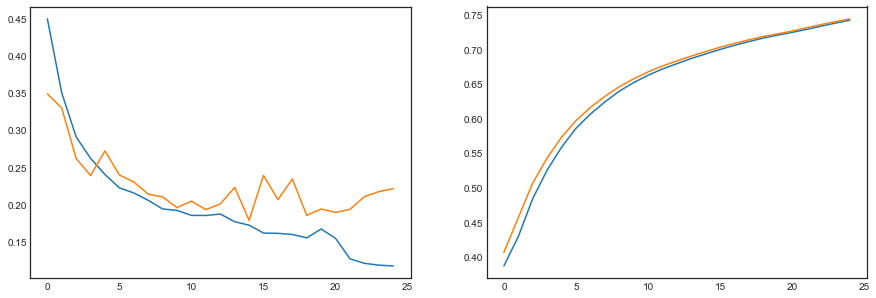

In [26]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))

ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mean_iou"], label="Train Mean_IoU")
ax_acc.plot(history.epoch, history.history["val_mean_iou"], label="Validation Mean_IoU")


In [17]:
best_model = load_model('../models/model-tgs-salt-validation-dropout-batchnorm-27-0.10.h5',
                       custom_objects={"mean_iou": mean_iou})

# Predict the validation set to do a sanity check

Again plot some sample images including the predictions.

In [53]:
preds_valid = best_model.predict(x_valid[:10]).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

ResourceExhaustedError: OOM when allocating tensor with shape[16,32,3,3]
	 [[Node: conv2d_207/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](concatenate_40/concat, conv2d_207/kernel/read)]]
	 [[Node: conv2d_209/Sigmoid/_1831 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1915_conv2d_209/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'conv2d_207/convolution', defined at:
  File "C:\Anaconda\envs\py35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda\envs\py35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Anaconda\envs\py35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda\envs\py35\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Anaconda\envs\py35\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Anaconda\envs\py35\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Anaconda\envs\py35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda\envs\py35\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Anaconda\envs\py35\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Anaconda\envs\py35\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Anaconda\envs\py35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Anaconda\envs\py35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Anaconda\envs\py35\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Anaconda\envs\py35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Anaconda\envs\py35\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Anaconda\envs\py35\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Anaconda\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Anaconda\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Anaconda\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-9a4b7634ded9>", line 2, in <module>
    custom_objects={"mean_iou": mean_iou})
  File "C:\Anaconda\envs\py35\lib\site-packages\keras\models.py", line 239, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "C:\Anaconda\envs\py35\lib\site-packages\keras\models.py", line 313, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "C:\Anaconda\envs\py35\lib\site-packages\keras\layers\__init__.py", line 54, in deserialize
    printable_module_name='layer')
  File "C:\Anaconda\envs\py35\lib\site-packages\keras\utils\generic_utils.py", line 139, in deserialize_keras_object
    list(custom_objects.items())))
  File "C:\Anaconda\envs\py35\lib\site-packages\keras\engine\topology.py", line 2497, in from_config
    process_node(layer, node_data)
  File "C:\Anaconda\envs\py35\lib\site-packages\keras\engine\topology.py", line 2454, in process_node
    layer(input_tensors[0], **kwargs)
  File "C:\Anaconda\envs\py35\lib\site-packages\keras\engine\topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Anaconda\envs\py35\lib\site-packages\keras\layers\convolutional.py", line 164, in call
    dilation_rate=self.dilation_rate)
  File "C:\Anaconda\envs\py35\lib\site-packages\keras\backend\tensorflow_backend.py", line 3164, in conv2d
    data_format='NHWC')
  File "C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 672, in convolution
    op=op)
  File "C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 338, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 664, in op
    name=name)
  File "C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 131, in _non_atrous_convolution
    name=name)
  File "C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 397, in conv2d
    data_format=data_format, name=name)
  File "C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[16,32,3,3]
	 [[Node: conv2d_207/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](concatenate_40/concat, conv2d_207/kernel/read)]]
	 [[Node: conv2d_209/Sigmoid/_1831 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1915_conv2d_209/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


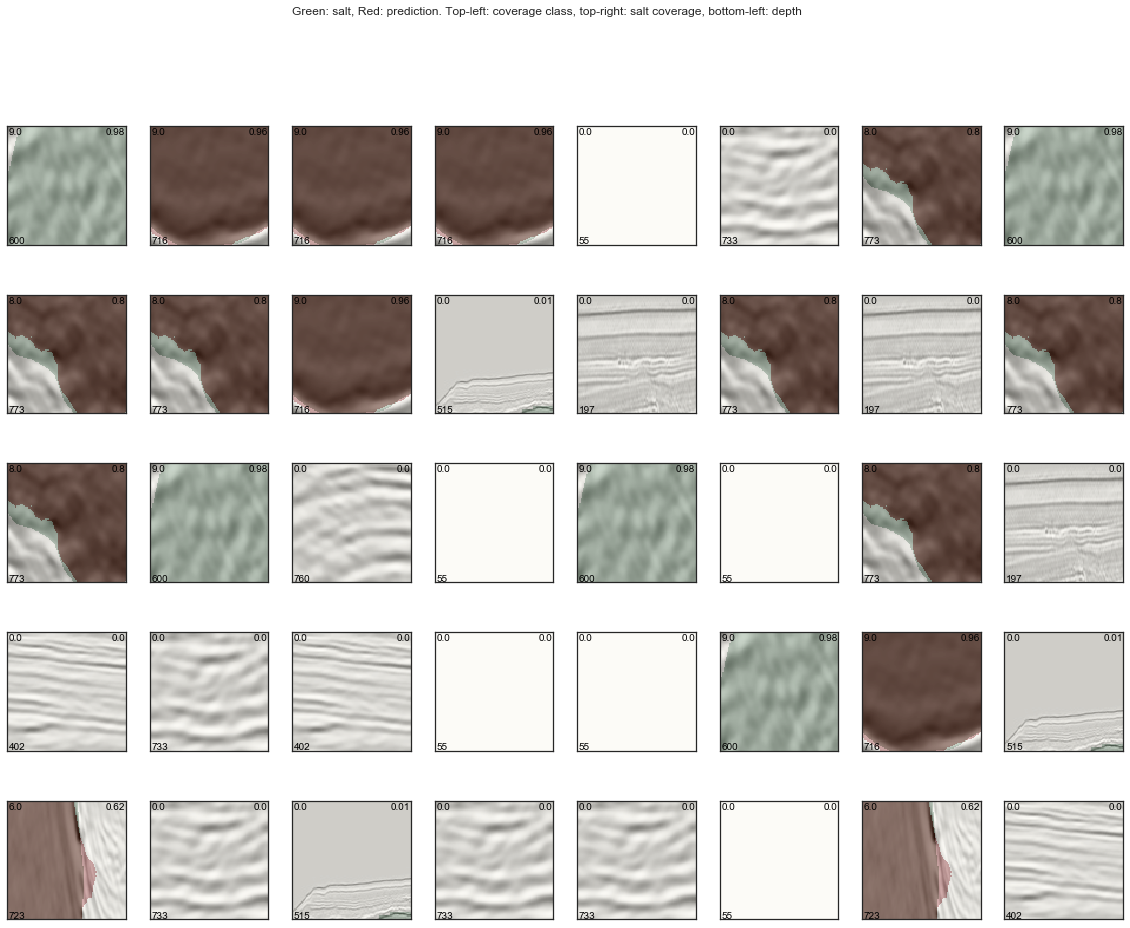

In [58]:
show_images(ids_valid[:10], images_folder= path_train + 'images', masks_folder= path_train + 'masks', predictions=preds_valid)

In [59]:


thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

IndexError: index 10 is out of bounds for axis 0 with size 10

In [33]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

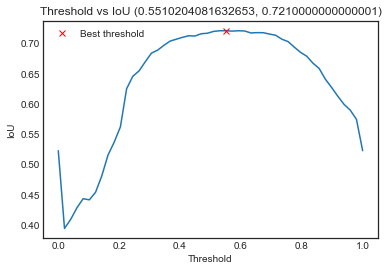

In [34]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Submission

In [38]:
x_test = np.array([upsample(np.array(load_img("../data/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

preds_test = best_model.predict(x_test)

A Jupyter Widget

In [39]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

A Jupyter Widget